### Cleaning Indeed Reviews Data

The goal from this dataset is to figure out:
- How different industries affect the work quality
- How different ranks affect the work quality
- How different occupations affect the work quality

### Basic Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [2]:
review_data = pd.read_excel('datasets/webscraping_indeed_unique_reviews_24112020.xlsx');

review_data.head(3)

,_OccupationRole,_Rank,Author,Company,Date,Employment,Occupation,Place,Review Raw,Review Removed Punctuation,Review Stopwords Removed,ReviewStopwordsRemoved2,Table Name,Rating
0,Sales,NaN,Retail Assistant (Former Employee) - City Hall...,Charles-&-Keith,2019-11-23,Former Employee,Retail Assistant,City Hall,Eazy cash for student who want to earn extra p...,Eazy cash for student who want to earn extra p...,"['eazy', 'cash', 'student', 'want', 'earn', 'e...",eazy cash student want earn extra pocket money...,webscraping_indeed_reviews_Charles-&-Keith2411...,3
1,NaN,NaN,Fashion Advisor (Former Employee) - Jurong poi...,Charles-&-Keith,2020-07-07,Former Employee,Fashion Advisor,Jurong point,Working in Charles and Keith is definitely a g...,Working in Charles and Keith is definitely a g...,"['working', 'charles', 'keith', 'definitely', ...",working charles keith definitely good opportun...,webscraping_indeed_reviews_Charles-&-Keith2411...,5
2,NaN,Manager,Boutique Manager (Current Employee) - Singapor...,Charles-&-Keith,2020-04-01,Current Employee,Boutique Manager,Singapore,Charles and Keith is a well known local brand ...,Charles and Keith is a well known local brand ...,"['charles', 'keith', 'well', 'known', 'local',...",charles keith well known local brand singapore...,webscraping_indeed_reviews_Charles-&-Keith2411...,3


---

We have the following features

ReviewStopwordsRemoved:
  - This can help us figure out type of benefits
  
Rank:
  - Position of the person

Occupation:
  - What jobs they do. This can help us get the industry
 
OccupationRole:
  - Effectively just what department they work at (e.g. a Lawyer in OCBC will still fall under law occupation Role)


---

In [3]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   _OccupationRole             1870 non-null   object        
 1   _Rank                       956 non-null    object        
 2   Author                      3315 non-null   object        
 3   Company                     3315 non-null   object        
 4   Date                        3315 non-null   datetime64[ns]
 5   Employment                  3315 non-null   object        
 6   Occupation                  3305 non-null   object        
 7   Place                       3312 non-null   object        
 8   Review Raw                  3314 non-null   object        
 9   Review Removed Punctuation  3315 non-null   object        
 10  Review Stopwords Removed    3149 non-null   object        
 11  ReviewStopwordsRemoved2     3066 non-null   object      

In [4]:
# Dropping rows and columns
review_data.drop(columns=['Table Name'] , inplace=True)
review_data.dropna(subset=['Occupation' , 'Review Raw' , 'Review Stopwords Removed' ,'ReviewStopwordsRemoved2'] , inplace=True)

### Industry and Occupation

In [5]:
print(review_data['Company'].unique())
print(review_data['_OccupationRole'].unique())
print(review_data['Occupation'].unique())
review_data[['Occupation' , 'Company']]

## There are only 10 unique companies, i can just manually label each based on their industry
## There is alot of occupation 

['Charles-&-Keith' 'Dbs-Bank' 'Giordano' 'Isetann-Department-Store'
 'M1-Limited' 'Ocbc-Bank' 'Singtel' 'Uniqlo' 'United-Overseas-Bank']
['Sales' nan 'Customer Service' 'Product' 'Marketing' 'Technician'
 'Analysts' 'Business Development' 'Administration' 'Engineering'
 'Finance/Accounts' 'Project Management']
['Retail Assistant' 'Fashion Advisor' 'Boutique Manager' ...
 'Part Time Bank Teller' 'contract staff' 'Senior Loans Manager']


,Occupation,Company
0,Retail Assistant,Charles-&-Keith
1,Fashion Advisor,Charles-&-Keith
2,Boutique Manager,Charles-&-Keith
3,Retail Assistant,Charles-&-Keith
4,Sales Associate,Charles-&-Keith
...,...,...
3310,Senior officer,United-Overseas-Bank
3311,Supervisor,United-Overseas-Bank
3312,Associate Officer,United-Overseas-Bank
3313,contract staff,United-Overseas-Bank


In [6]:
## handling industry (easy)
company_to_industry_map = {
  'Charles-&-Keith': 'Fashion Retail',
  'Dbs-Bank': 'Banking & Finance',
  'Giordano': 'Apparel Retail',
  'Isetann-Department-Store': 'General Retail',
  'M1-Limited': 'Telecommunications',
  'Ocbc-Bank': 'Banking & Finance',
  'Singtel': 'Telecommunications',
  'Uniqlo': 'Fashion Retail',
  'United-Overseas-Bank': 'Banking & Finance',
  'Starhub': 'Telecommunications',
}

def createIndustry(company_name):
  global company_to_industry_map
  return company_to_industry_map[company_name]


review_data['Industry'] = review_data['Company'].apply(createIndustry)

review_data['Industry']

0          Fashion Retail
1          Fashion Retail
2          Fashion Retail
3          Fashion Retail
4          Fashion Retail
              ...        
3310    Banking & Finance
3311    Banking & Finance
3312    Banking & Finance
3313    Banking & Finance
3314    Banking & Finance
Name: Industry, Length: 3055, dtype: object

### Keyword Selection For Occupational Roles

In [7]:
department_keywords = {
    'Sales': [
        'sales', 'associate', 'account executive', 'business development',
        'representative', 'retail', 'promoter', 'consultant', 'telesales',
        'cashier', 'client advisor', 'store', 'floor staff', 'merchandiser',
        'customer advisor'
    ],
    'Customer Service': [
        'customer service', 'service representative', 'call center', 'support',
        'helpdesk', 'advisor', 'client care', 'relationship officer',
        'service associate', 'service coordinator', 'support specialist',
        'care officer'
    ],
    'Product': [
        'product manager', 'product owner', 'product specialist',
        'product designer', 'vendor', 'merchandiser', 'visual merchandiser',
        'inventory', 'product developer', 'product coordinator'
    ],
    'Marketing': [
        'marketing', 'brand manager', 'digital marketing', 'content creator',
        'seo', 'sem', 'social media', 'campaign manager', 'media buyer',
        'advertising', 'communications', 'promoter', 'public relations'
    ],
    'Technician': [
        'technician', 'maintenance', 'field tech', 'repair',
        'technical support', 'it technician', 'systems technician',
        'network technician', 'engineering tech'
    ],
    'Analysts': [
        'analyst', 'data analyst', 'business analyst', 'research', 'insights',
        'reporting', 'financial analyst', 'market analyst', 'operations analyst'
    ],
    'Business Development': [
        'business development', 'partnership manager', 'growth manager',
        'strategic partnerships', 'sales development', 'alliances',
        'account manager', 'commercial manager'
    ],
    'Administration': [
        'administration', 'admin', 'secretary', 'executive assistant',
        'office manager', 'clerk', 'receptionist', 'coordinator',
        'office assistant', 'administrative officer'
    ],
    'Engineering': [
        'engineer', 'software engineer', 'mechanical engineer',
        'electrical engineer', 'civil engineer', 'systems engineer',
        'network engineer', 'developer', 'full stack', 'backend', 'frontend',
        'technical lead'
    ],
    'Finance/Accounts': [
        'finance', 'accounting', 'accountant', 'financial officer', 'treasury',
        'auditor', 'controller', 'accounts payable', 'accounts receivable',
        'investment', 'banking', 'credit analyst'
    ],
    'Project Management': [
        'project manager', 'program manager', 'scrum master', 'agile coach',
        'project coordinator', 'delivery manager', 'project lead',
        'implementation manager'
    ],
    'Management': [
      'manager',  'supervisor', 'director', 'team lead', 'coordinator',
    'executive', 'administrator', 'chief', 'head of', 'lead',  
    ]
}


def imputeOccupationRole(row):
  value = row['Occupation']
  occupation_role = row['_OccupationRole']

  # no impute non-null values
  if pd.notna(occupation_role):
     return occupation_role

  global department_keywords
  occupation_list = value.lower().split(' ')

  for key , keywords_list in department_keywords.items():

    # going through the keywords for given key
    for keyword in keywords_list:
        if keyword in occupation_list:
           return key
        
        if len(keyword.split(' ')) > 1: # For words like 'program manager'
           if keyword in value.lower():  # direct check if exists in occupation
             return key
  
  ## Unable to group, return nan
  return np.nan


review_data['_OccupationRole'] = review_data.apply(imputeOccupationRole , axis=1)


In [8]:
review_data[['_OccupationRole' , 'Occupation']]

,_OccupationRole,Occupation
0,Sales,Retail Assistant
1,Customer Service,Fashion Advisor
2,Management,Boutique Manager
3,Sales,Retail Assistant
4,Sales,Sales Associate
...,...,...
3310,NaN,Senior officer
3311,Management,Supervisor
3312,Sales,Associate Officer
3313,NaN,contract staff


### Benefits Extraction

In [9]:
# Using LDA to extract the occupation departments
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# vectorising the occupations
vectoriser = CountVectorizer(stop_words="english")
data_matrix = vectoriser.fit_transform(review_data['ReviewStopwordsRemoved2'].values.flatten())
features = vectoriser.get_feature_names_out()

In [10]:
def displayTopicsKeywords(components):
  for index , topic in enumerate(components):
    features_index = topic.argsort()[::-1][:5]
    likely_features = [features[i] for i in features_index]
    print(f"Topic {index + 1}: {likely_features}")

In [11]:
for k in range(20, 31):
  lda= LatentDirichletAllocation(n_components=k , random_state=42)
  lda.fit(data_matrix)
  print('-----------------------------------------')
  print(f'Results for n-topics = {k}')
  displayTopicsKeywords(lda.components_)

-----------------------------------------
Results for n-topics = 20
Topic 1: ['good', 'work', 'job', 'company', 'great']
Topic 2: ['work', 'working', 'good', 'environment', 'team']
Topic 3: ['management', 'working', 'communication', 'new', 'culture']
Topic 4: ['job', 'team', 'customers', 'high', 'engage']
Topic 5: ['les', 'des', 'très', 'est', 'pour']
Topic 6: ['people', 'work', 'customers', 'job', 'management']
Topic 7: ['sales', 'store', 'customer', 'floor', 'customers']
Topic 8: ['work', 'company', 'day', 'life', 'place']
Topic 9: ['management', 'company', 'project', 'need', 'learning']
Topic 10: ['work', 'customers', 'sales', 'dont', 'employees']
Topic 11: ['job', 'company', 'need', 'working', 'que']
Topic 12: ['die', 'und', 'dan', 'das', 'managers']
Topic 13: ['learn', 'really', 'new', 'long', 'clients']
Topic 14: ['customers', 'customer', 'job', 'service', 'work']
Topic 15: ['management', 'skills', 'great', 'customer', 'job']
Topic 16: ['work', 'job', 'time', 'store', 'day']
Topi

In [12]:
# Though a brief view of the data, i decided to take the results for n-topic  = 25
# Using the existing values of 
lda= LatentDirichletAllocation(n_components= 25 , random_state=42)
lda.fit(data_matrix)
displayTopicsKeywords(lda.components_)


Topic 1: ['work', 'job', 'great', 'good', 'management']
Topic 2: ['work', 'job', 'working', 'customers', 'team']
Topic 3: ['management', 'need', 'faut', 'par', 'improvement']
Topic 4: ['job', 'people', 'customers', 'clothes', 'like']
Topic 5: ['les', 'des', 'très', 'pour', 'est']
Topic 6: ['people', 'work', 'customer', 'job', 'great']
Topic 7: ['sales', 'high', 'work', 'floor', 'customers']
Topic 8: ['day', 'company', 'clients', 'work', 'like']
Topic 9: ['management', 'project', 'organisation', 'learning', 'time']
Topic 10: ['work', 'customers', 'managers', 'help', 'job']
Topic 11: ['company', 'job', 'que', 'managers', 'working']
Topic 12: ['die', 'und', 'das', 'que', 'dan']
Topic 13: ['customer', 'management', 'long', 'good', 'new']
Topic 14: ['customers', 'job', 'work', 'customer', 'sales']
Topic 15: ['management', 'working', 'great', 'customer', 'skills']
Topic 16: ['job', 'time', 'work', 'skills', 'people']
Topic 17: ['management', 'company', 'employees', 'job', 'fair']
Topic 18: [

In [13]:
# After breif analysis, can create a map of what each review main topic is about again its 
topic_groups = {
    'Work Environment & Culture': [1, 2, 3, 8, 21, 22],
    'Management & Staff': [3, 9, 11, 15, 17, 19],
    'Customer Relations': [10, 14, 24, 25],
    'Job & Career Growth': [6, 16, 23],
    'Retail & Store Experience': [4, 7, 18],
    'Foreign': [5, 12, 13],
    'Financial/Banking': [20, 25],
}


topic_weights = lda.transform(data_matrix)
topic_weights = np.argmax(topic_weights , axis=1) + 1 # get the max weight index in each row 

def createReviewTopic(index):
  for key , indices in topic_groups.items():
    if index in indices:
      return key


review_data['topic_weights'] = topic_weights
review_data['review_topics'] = review_data['topic_weights'].apply(createReviewTopic)



In [14]:

# Using blox text sentiment, i will extract the polarity and subjectivity
from textblob import TextBlob

def extractSentiment(review):
  sentiment = TextBlob(review).sentiment
  return pd.Series([sentiment.polarity , sentiment.subjectivity])

review_data[['review polarity' , 'review subjectivity']] = review_data['Review Raw'].apply(extractSentiment)

In [15]:
## Final display of table head to show all changes made
review_data.head(3)


,_OccupationRole,_Rank,Author,Company,Date,Employment,Occupation,Place,Review Raw,Review Removed Punctuation,Review Stopwords Removed,ReviewStopwordsRemoved2,Rating,Industry,topic_weights,review_topics,review polarity,review subjectivity
0,Sales,NaN,Retail Assistant (Former Employee) - City Hall...,Charles-&-Keith,2019-11-23,Former Employee,Retail Assistant,City Hall,Eazy cash for student who want to earn extra p...,Eazy cash for student who want to earn extra p...,"['eazy', 'cash', 'student', 'want', 'earn', 'e...",eazy cash student want earn extra pocket money...,3,Fashion Retail,24,Customer Relations,0.100000,0.500000
1,Customer Service,NaN,Fashion Advisor (Former Employee) - Jurong poi...,Charles-&-Keith,2020-07-07,Former Employee,Fashion Advisor,Jurong point,Working in Charles and Keith is definitely a g...,Working in Charles and Keith is definitely a g...,"['working', 'charles', 'keith', 'definitely', ...",working charles keith definitely good opportun...,5,Fashion Retail,22,Work Environment & Culture,0.366667,0.533333
2,Management,Manager,Boutique Manager (Current Employee) - Singapor...,Charles-&-Keith,2020-04-01,Current Employee,Boutique Manager,Singapore,Charles and Keith is a well known local brand ...,Charles and Keith is a well known local brand ...,"['charles', 'keith', 'well', 'known', 'local',...",charles keith well known local brand singapore...,3,Fashion Retail,2,Work Environment & Culture,0.138889,0.352778


### Plottings

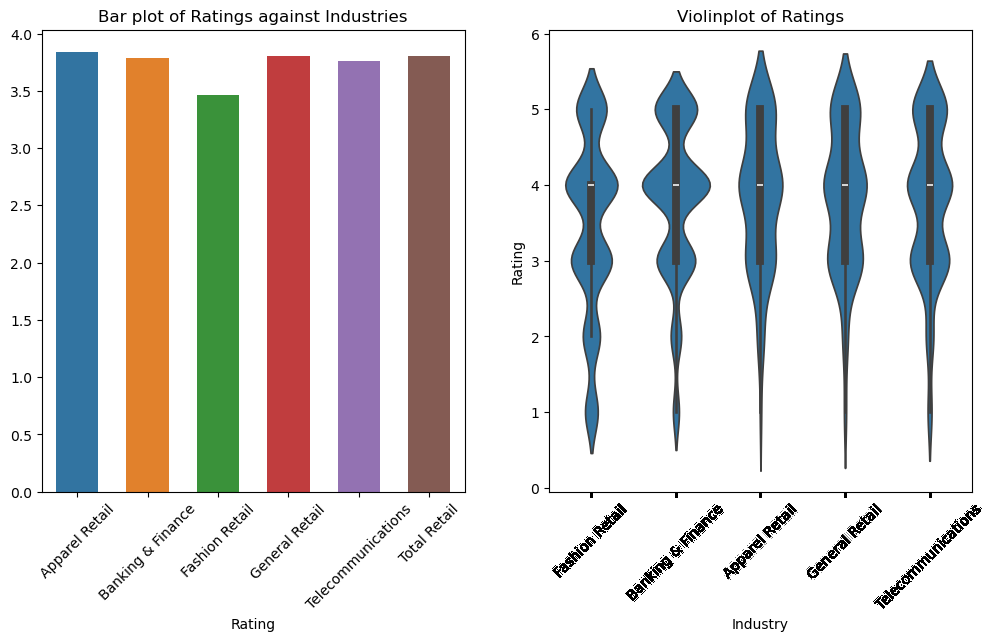

,Rating
Industry,
Apparel Retail,3.841463
Banking & Finance,3.786580
Fashion Retail,3.459170
General Retail,3.805556
Telecommunications,3.758389
Total Retail,3.805556


In [16]:
grouped_by_industry = review_data[['Industry' , 'Rating']].groupby(by='Industry').mean()

# I also want to 'group' the retails tgt
mean_retail_rating = grouped_by_industry.loc[['General Retail' , 'Apparel Retail' ,'Fashion Retail'] , :].median()

# adding to the df
grouped_by_industry.loc['Total Retail'] = mean_retail_rating

# Plottings
X = grouped_by_industry.index
y = grouped_by_industry['Rating'].values

fig , axes = plt.subplots(1 , 2 ,figsize=(12 , 6))

# Bar plot
sns.barplot(x=X , y=y , hue=X , width=0.6 , ax=axes[0])
axes[0].set_xticks(ticks=X , labels=X , rotation=45)
axes[0].set_xlabel('Rating')
axes[0].set_title('Bar plot of Ratings against Industries')


# Box plot
X = review_data['Industry']
sns.violinplot(x=X , y=review_data['Rating'] , ax=axes[1])
axes[1].set_xticks(ticks=X, labels=X , rotation=45)
axes[1].set_title('Violinplot of Ratings')

plt.show()

grouped_by_industry

In [20]:
# Selecting numerical columns along with 'Industry' and 'Company'
categorical_columns = ['Industry', 'Company']
numerical_columns = ['Rating', 'topic_weights', 'review polarity', 'review subjectivity']

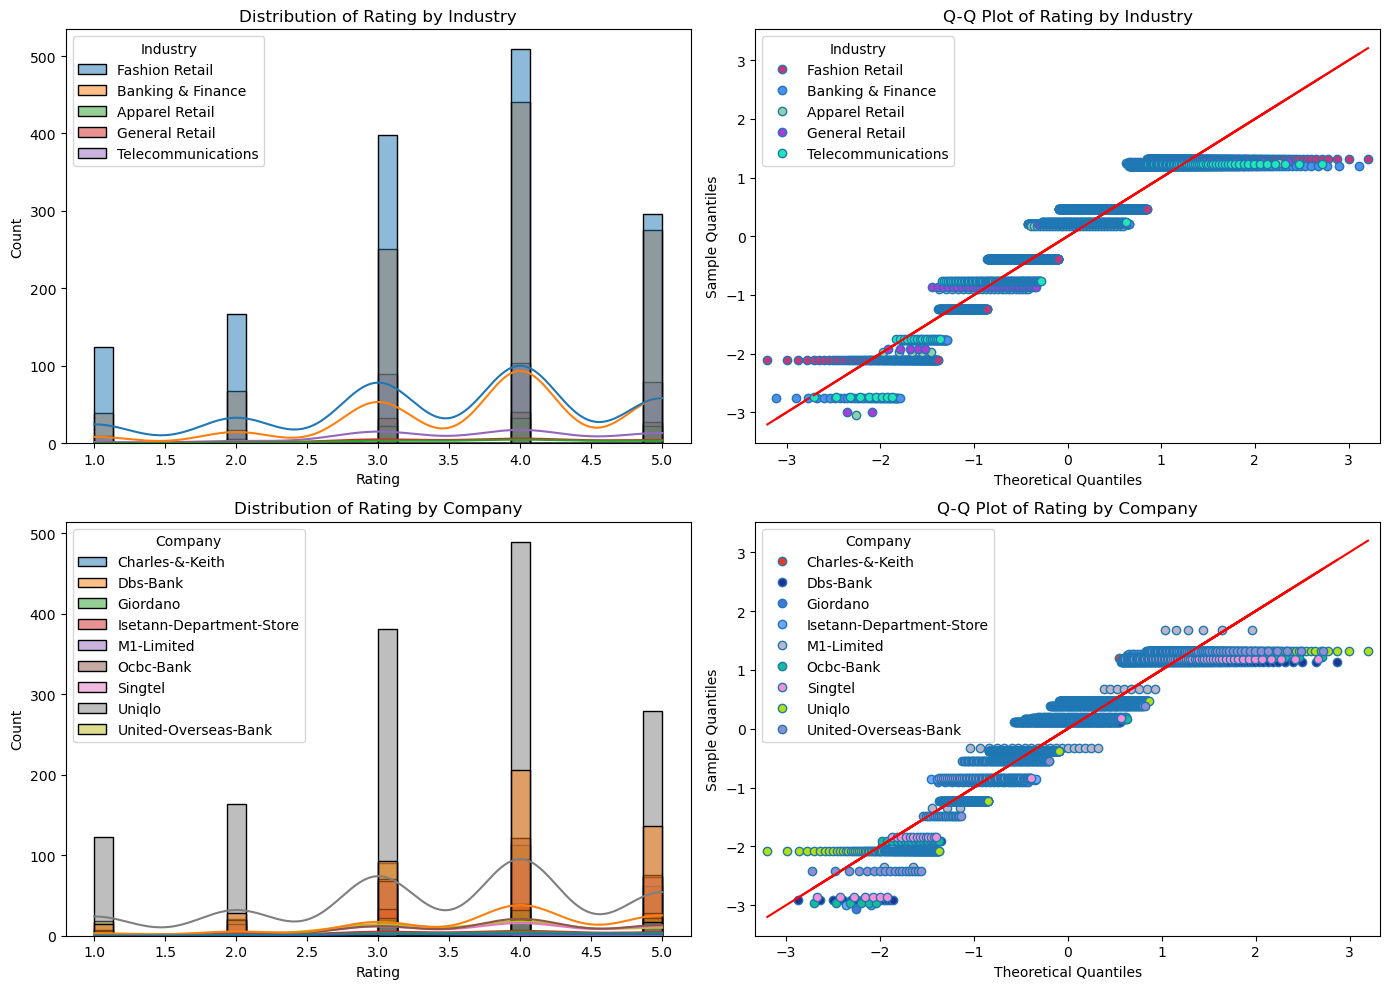

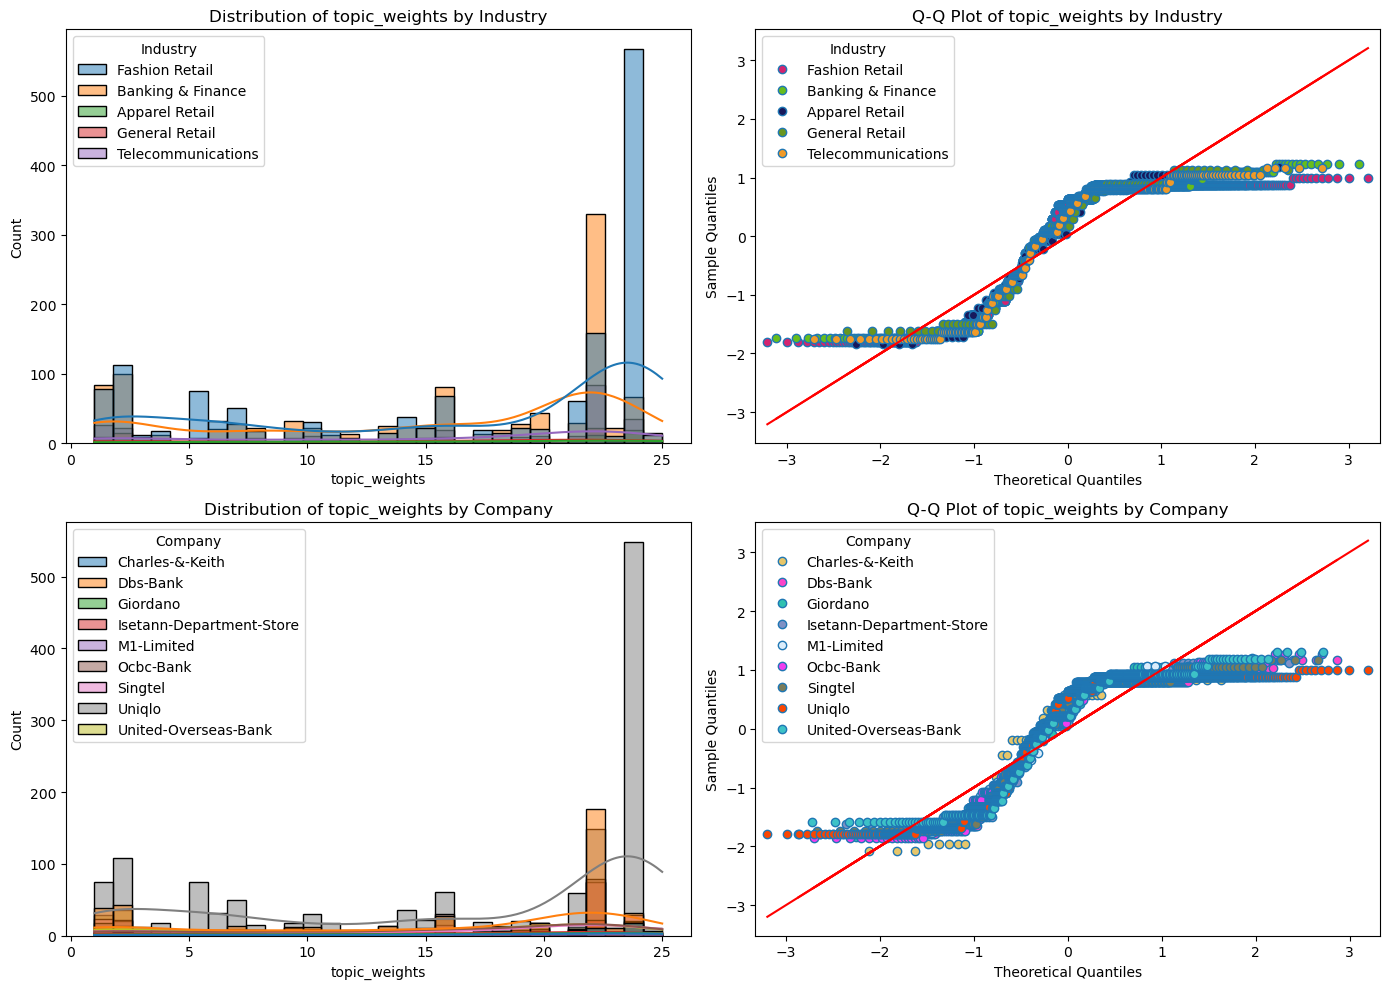

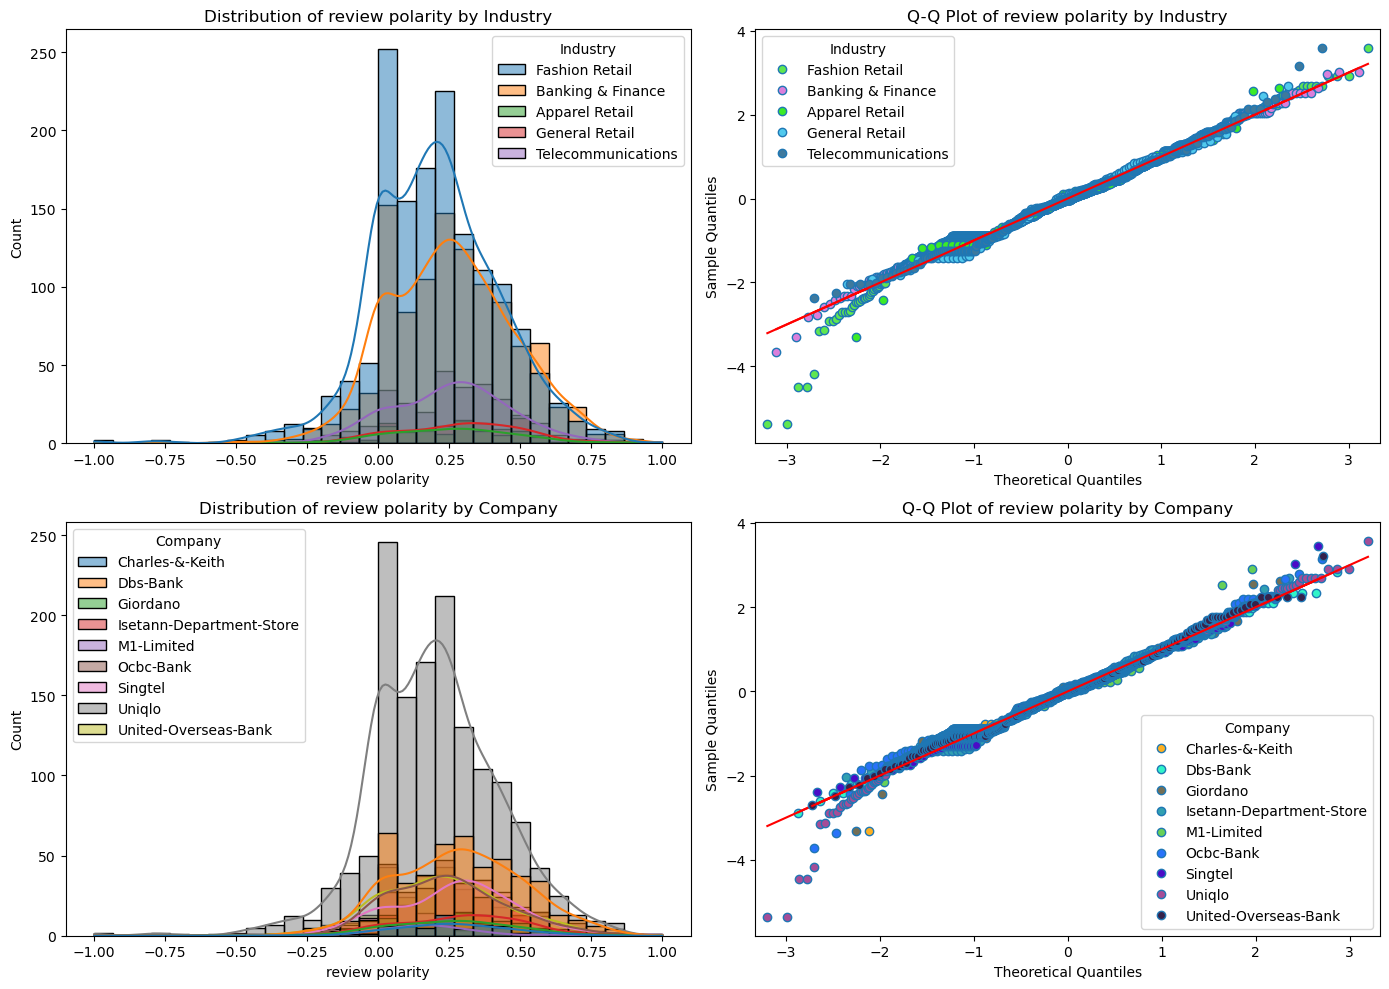

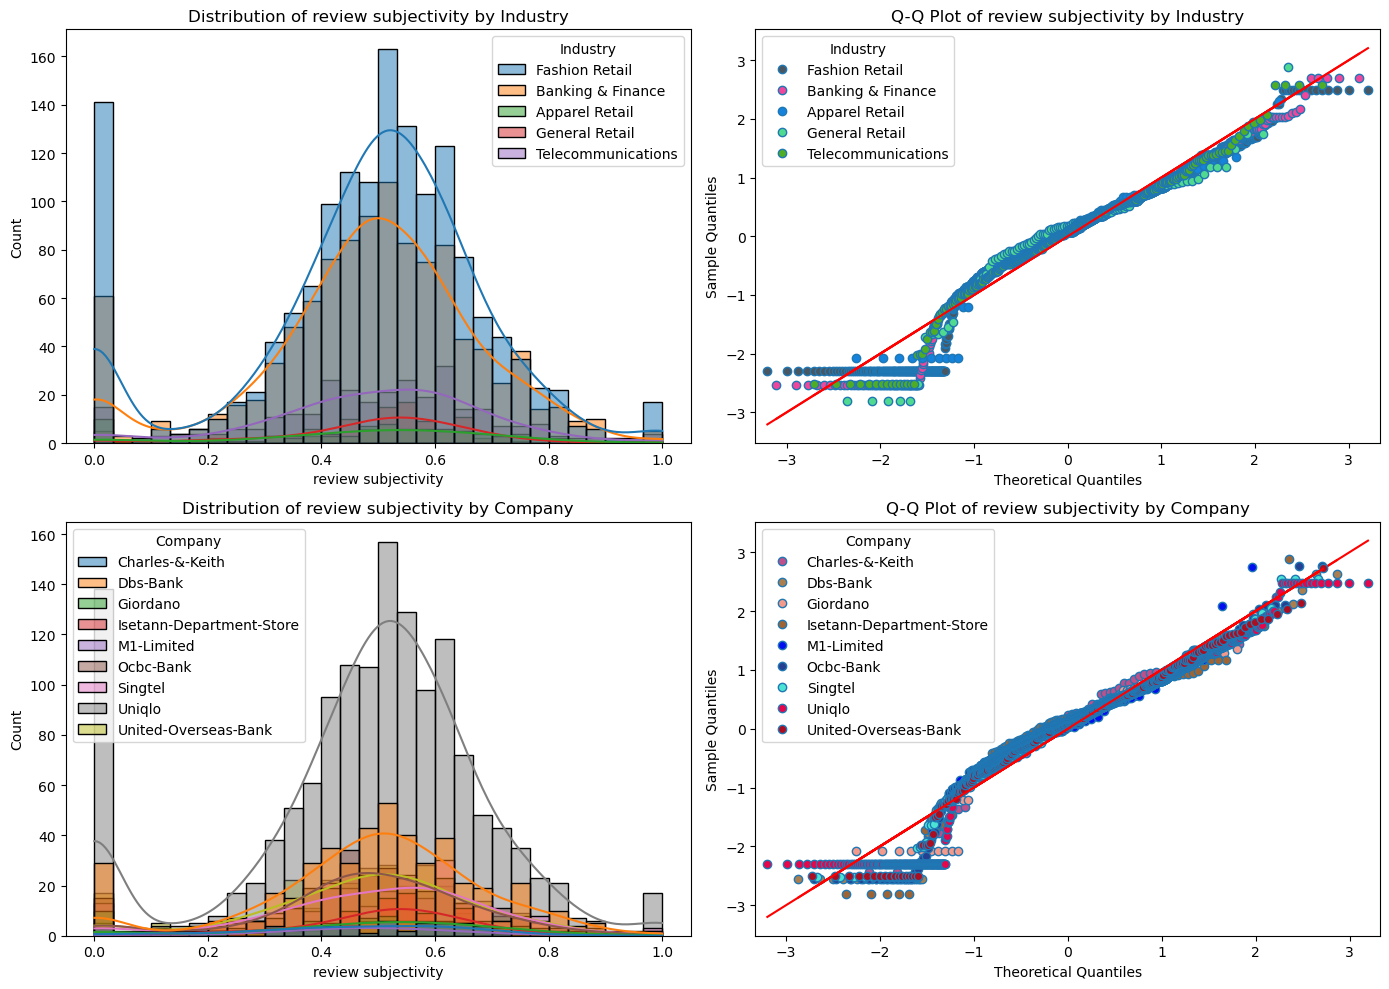

In [21]:
# visualizes the distribution of numerical columns in review_data by Industry and Company using histograms with KDE and Q-Q plots.
import statsmodels.api as sm
import random  # Import the random module

# Example: Assigning colors dynamically
# Assign a random color
# Generate a random color
def get_random_color():
    return (random.random(), random.random(), random.random())  # RGB tuple

# Loop through each numerical column
for col in numerical_columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns layout
    
    ## PLOT FOR INDUSTRY ##
    # Histogram + KDE
    sns.histplot(data=review_data, x=col, hue="Industry", bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f"Distribution of {col} by Industry")
    axes[0, 0].set_xlabel(col)
    axes[0, 0].set_ylabel("Count")

    # Q-Q Plot
    for industry in review_data["Industry"].unique():
        random_color = get_random_color()
        sm.qqplot(review_data[review_data["Industry"] == industry][col].dropna(), line="s", fit=True, ax=axes[0, 1], **{'markerfacecolor': random_color}, label=industry)
    axes[0, 1].set_title(f"Q-Q Plot of {col} by Industry")
    axes[0, 1].legend(title="Industry")

    ## PLOT FOR COMPANY ##
    # Histogram + KDE
    sns.histplot(data=review_data, x=col, hue="Company", bins=30, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f"Distribution of {col} by Company")
    axes[1, 0].set_xlabel(col)
    axes[1, 0].set_ylabel("Count")

    # Q-Q Plot
    for company in review_data["Company"].unique():
        random_color = get_random_color()
        sm.qqplot(review_data[review_data["Company"] == company][col].dropna(), line="s", fit=True, ax=axes[1, 1], **{'markerfacecolor': random_color}, label=company)
    axes[1, 1].set_title(f"Q-Q Plot of {col} by Company")
    axes[1, 1].legend(title="Company")

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()



##### Polarity

All of the plots are generally normally distributed

Though there is some negative skewed data, which are most likely outliers 

Looking closely at the plots the negative skewed data is from Fashion Retail

However overall, the data seems to be congregated between 0 to 0.25, suggesting that most reviews are mildly or completely neutral

##### Subjectivity

For all the plots, there seems to be a concentration around the 0.4-0.6 region, suggesting that most of the reviews are moderately subjective

This can mean that most of the reviews are opinions, less 'factually spoken'

##### Topic Weights

For **Banking and Finance**, most of the reviews are regarding Topic 22 (Work Environment)

For **Fashion Retail**, most of the reviews are regarding Topic 24 (Customer Relations)

With both its polarity peaking around 0.2 to 0.3 it suggests that its respective topics are quite good


In [ ]:
industry_polarity_group = review_data.pivot_table(columns='Industry' , values='polarity' , 


Outliers for Rating in Industry - Apparel Retail:
  Max Outlier: 5.00
  Min Outlier: 1.00

Outliers for Rating in Industry - Banking & Finance:
  Max Outlier: 5.00
  Min Outlier: 1.00

Outliers for Rating in Industry - Fashion Retail:
  Max Outlier: 5.00
  Min Outlier: 1.00

Outliers for Rating in Industry - General Retail:
  Max Outlier: 5.00
  Min Outlier: 1.00

Outliers for Rating in Industry - Telecommunications:
  Max Outlier: 5.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Apparel Retail:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Banking & Finance:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Fashion Retail:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - General Retail:
  Max Outlier: 24.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Telecommunications:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for review polarity in Ind

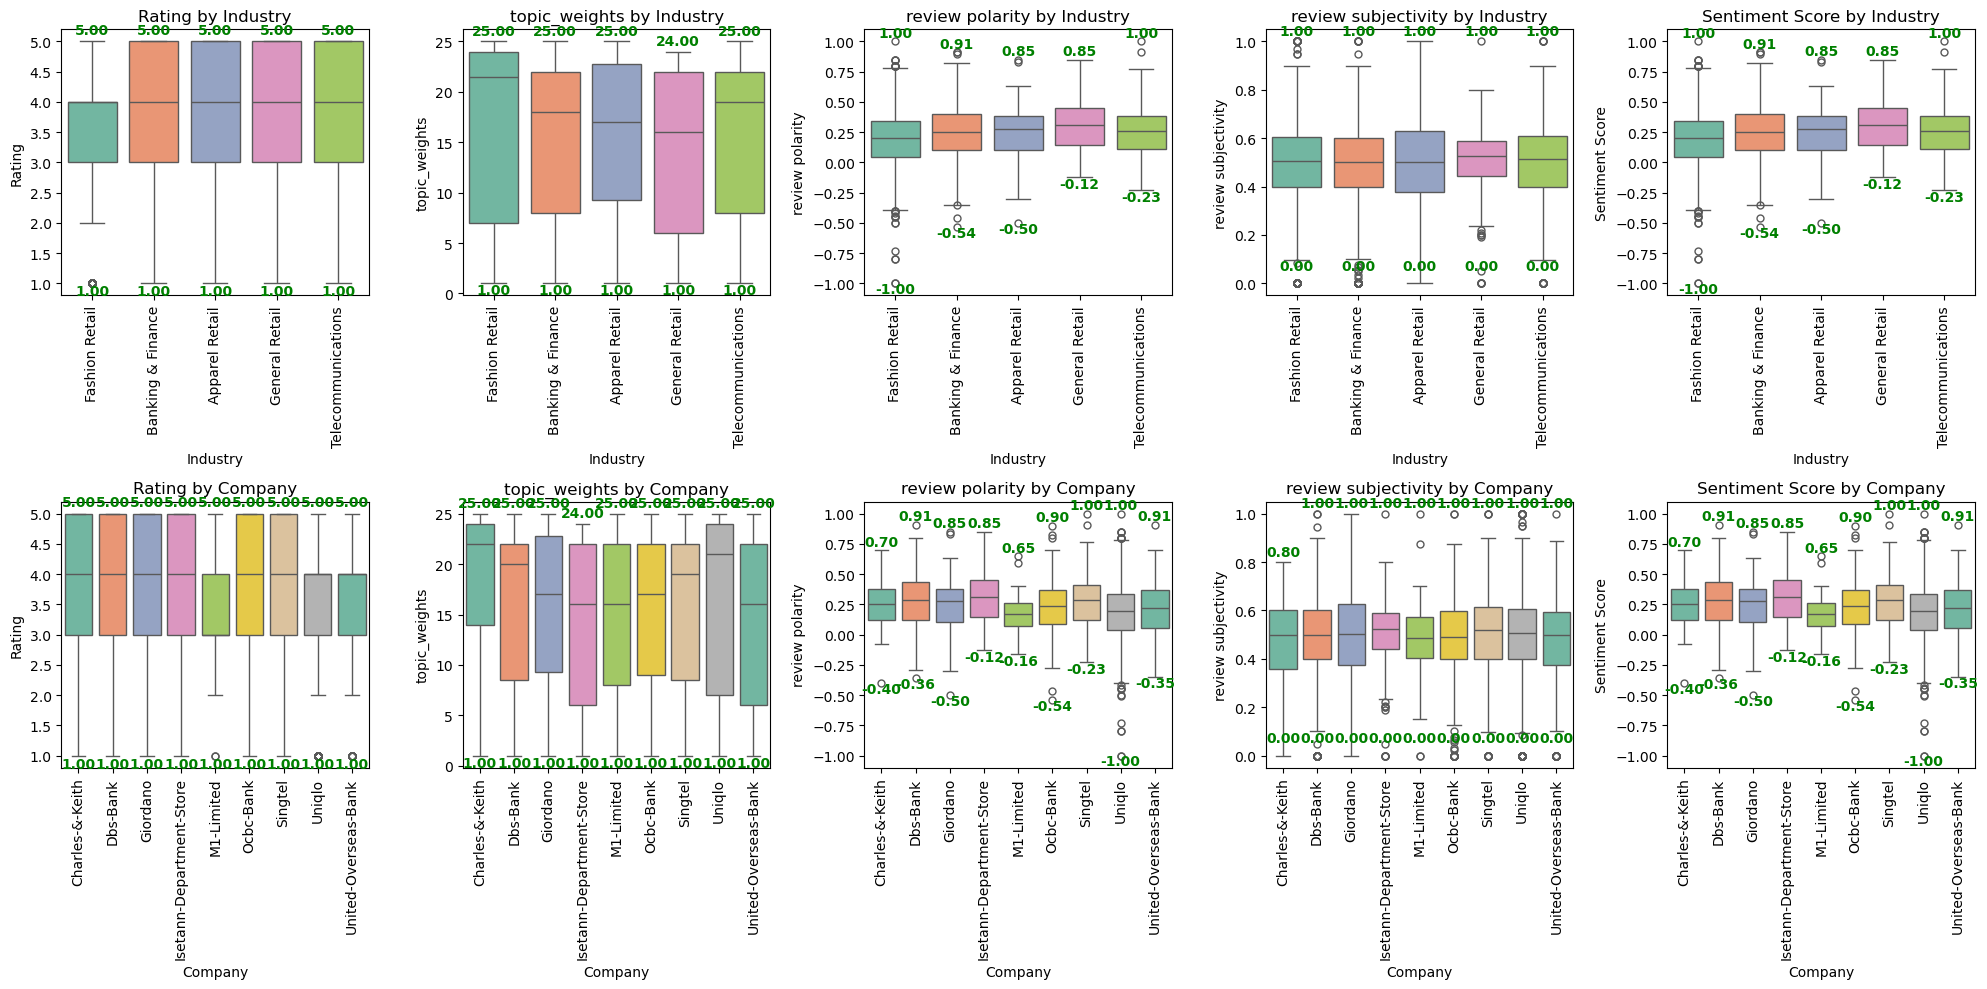

In [ ]:
# visualizing numerical data distributions by Industry and Company using boxplots while identifying and annotating outliers.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to print and annotate max and min outliers **for each category**
def annotate_outliers(ax, category_col, value_col):
    grouped_outliers = review_data.groupby(category_col)

    for category, group in grouped_outliers:
        if group.empty:
            continue  # Skip if no outliers exist

        # Get max and min outliers within each category
        max_flier = group[value_col].max()
        min_flier = group[value_col].min()

        # Get index of max and min outliers
        max_flier_index = group[value_col].idxmax()
        min_flier_index = group[value_col].idxmin()

        # Print max and min outliers per category
        print(f"\nOutliers for {value_col} in {category_col} - {category}:")
        print(f"  Max Outlier: {max_flier:.2f}")
        print(f"  Min Outlier: {min_flier:.2f}")

        # Get coordinates
        x_max = category
        y_max = group.loc[max_flier_index, value_col]
        x_min = category
        y_min = group.loc[min_flier_index, value_col]

        # Define offsets
        offset_max = (y_max * 0.015) if y_max != 0 else 0.1  # 5% of value or 0.1 if y=0
        offset_min = (y_min * 0.015) if y_min != 0 else -0.1  # 5% of value or -0.1 if y=0

        # Annotate points with offsets
        ax.text(x_max, y_max + offset_max, f'{max_flier:.2f}', color='green', fontsize=10, ha='center', va='bottom', fontweight='bold')
        ax.text(x_min, y_min - offset_min, f'{min_flier:.2f}', color='green', fontsize=10, ha='center', va='top', fontweight='bold')


# Create subplots
fig, axMany = plt.subplots(2, len(numerical_columns), figsize=(20, 10), squeeze=False)

# Plot numerical columns grouped by Industry (First Row)
for colCnt, item in enumerate(numerical_columns):
    ax = axMany[0, colCnt]
    
    sns.boxplot(x=review_data["Industry"], y=review_data[item], ax=ax, hue=review_data["Industry"],palette=palette,
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    
    ax.set_title(f"{item} by Industry")
    ax.tick_params(axis='x', rotation=90)

    # Annotate and print max/min outliers per category
    annotate_outliers(ax, "Industry", item)

# Plot numerical columns grouped by Company (Second Row)
for colCnt, item in enumerate(numerical_columns):
    ax = axMany[1, colCnt]

    sns.boxplot(x=review_data["Company"], y=review_data[item], ax=ax, hue=review_data["Company"],palette=palette,
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    
    ax.set_title(f"{item} by Company")
    ax.tick_params(axis='x', rotation=90)

    # Annotate and print max/min outliers per category
    annotate_outliers(ax, "Company", item)

# Adjust layout
plt.tight_layout()
plt.show()


Original Data Shape: (3055, 19)
Data Shape After Outlier Removal: (2623, 19)

Outliers for Rating in Industry - Apparel Retail:
  Max Outlier: 5.00
  Min Outlier: 2.00

Outliers for Rating in Industry - Banking & Finance:
  Max Outlier: 5.00
  Min Outlier: 2.00

Outliers for Rating in Industry - Fashion Retail:
  Max Outlier: 5.00
  Min Outlier: 2.00

Outliers for Rating in Industry - General Retail:
  Max Outlier: 5.00
  Min Outlier: 2.00

Outliers for Rating in Industry - Telecommunications:
  Max Outlier: 5.00
  Min Outlier: 2.00

Outliers for topic_weights in Industry - Apparel Retail:
  Max Outlier: 24.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Banking & Finance:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Fashion Retail:
  Max Outlier: 25.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - General Retail:
  Max Outlier: 24.00
  Min Outlier: 1.00

Outliers for topic_weights in Industry - Telecommunications:


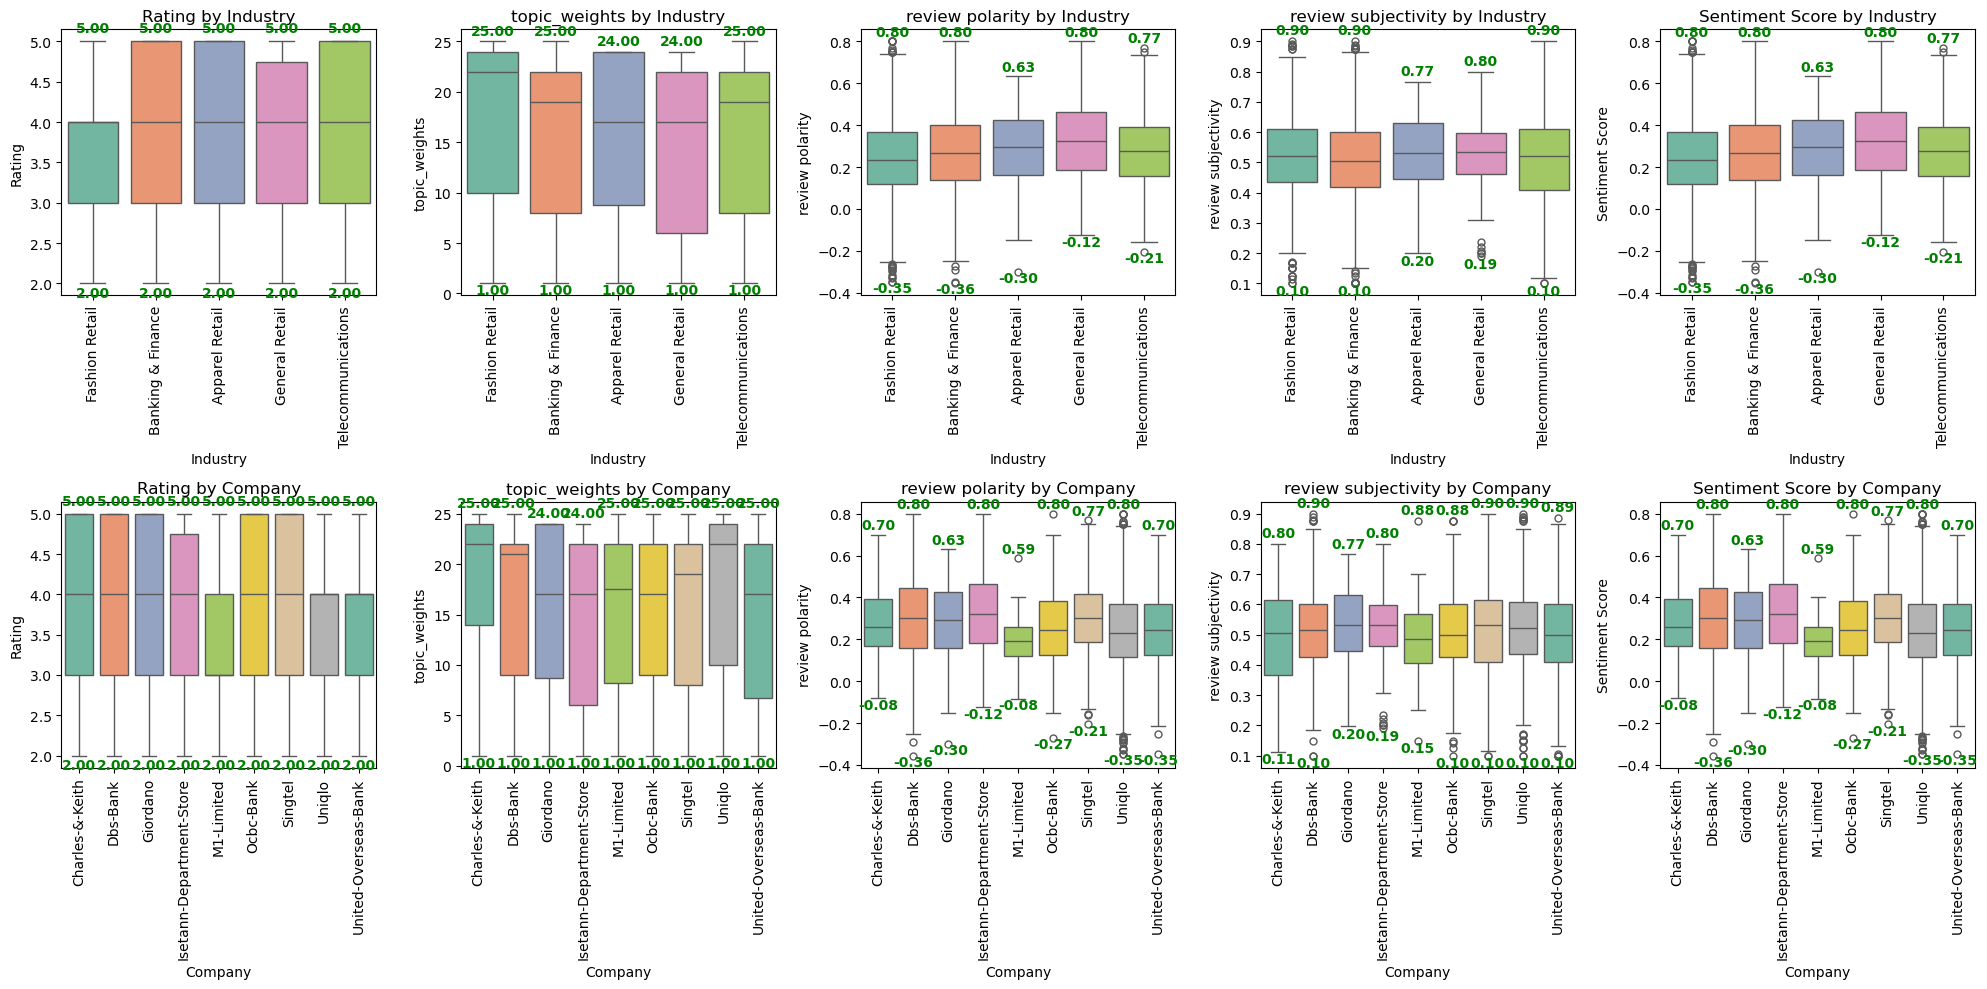

In [ ]:
# Removing outliers using the IQR (Interquartile Range) method and then visualizing the cleaned data using boxplots while still identifying max/min values per category.
#Remove the outlier box the IQR
Q1 = review_data[numerical_columns].quantile(0.25)
Q3 = review_data[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtering the data to remove outliers
df_out = review_data[~((review_data[numerical_columns] < (Q1 - 1.5 * IQR)) | (review_data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Print the shape before and after outlier removal
print("Original Data Shape:", review_data.shape)
print("Data Shape After Outlier Removal:", df_out.shape)

# Define a color palette
palette = "Set2"

# Function to print and annotate max and min outliers **for each category**
def annotate_outliers(ax, category_col, value_col):
    grouped_outliers = df_out.groupby(category_col)

    for category, group in grouped_outliers:
        if group.empty:
            continue  # Skip if no outliers exist

        # Get max and min outliers within each category
        max_flier = group[value_col].max()
        min_flier = group[value_col].min()

        # Get index of max and min outliers
        max_flier_index = group[value_col].idxmax()
        min_flier_index = group[value_col].idxmin()

        # Print max and min outliers per category
        print(f"\nOutliers for {value_col} in {category_col} - {category}:")
        print(f"  Max Outlier: {max_flier:.2f}")
        print(f"  Min Outlier: {min_flier:.2f}")

        # Get coordinates
        x_max = category
        y_max = group.loc[max_flier_index, value_col]
        x_min = category
        y_min = group.loc[min_flier_index, value_col]

        # Define offsets
        offset_max = (y_max * 0.015) if y_max != 0 else 0.1  # 5% of value or 0.1 if y=0
        offset_min = (y_min * 0.015) if y_min != 0 else -0.1  # 5% of value or -0.1 if y=0

        # Annotate points with offsets
        ax.text(x_max, y_max + offset_max, f'{max_flier:.2f}', color='green', fontsize=10, ha='center', va='bottom', fontweight='bold')
        ax.text(x_min, y_min - offset_min, f'{min_flier:.2f}', color='green', fontsize=10, ha='center', va='top', fontweight='bold')


# Create subplots
fig, axMany = plt.subplots(2, len(numerical_columns), figsize=(20, 10), squeeze=False)

# Plot numerical columns grouped by Industry (First Row)
for colCnt, item in enumerate(numerical_columns):
    ax = axMany[0, colCnt]
    
    sns.boxplot(x=df_out["Industry"], y=df_out[item], ax=ax, hue=df_out["Industry"],palette=palette,
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    
    ax.set_title(f"{item} by Industry")
    ax.tick_params(axis='x', rotation=90)

    # Annotate and print max/min outliers per category
    annotate_outliers(ax, "Industry", item)

# Plot numerical columns grouped by Company (Second Row)
for colCnt, item in enumerate(numerical_columns):
    ax = axMany[1, colCnt]

    sns.boxplot(x=df_out["Company"], y=df_out[item], ax=ax, hue=df_out["Company"],palette=palette,
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    
    ax.set_title(f"{item} by Company")
    ax.tick_params(axis='x', rotation=90)

    # Annotate and print max/min outliers per category
    annotate_outliers(ax, "Company", item)

# Adjust layout
plt.tight_layout()
plt.show()

